In [17]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [18]:
df_order_historic_demand = pd.read_excel('C:/Users/JWinn01/Desktop/IABD/material/datos/Datos_P1/df_historic_order_demand.xlsx')
df_distances = pd.read_excel('C:/Users/JWinn01/Desktop/IABD/material/datos/Datos_P1/df_distance_km.xlsx')
df_distance_min = pd.read_excel('C:/Users/JWinn01/Desktop/IABD/material/datos/Datos_P1/df_distance_min.xlsx')
df_location = pd.read_excel('C:/Users/JWinn01/Desktop/IABD/material/datos/Datos_P1/df_location.xlsx')
df_customers = pd.read_excel('C:/Users/JWinn01/Desktop/IABD/material/datos/Datos_P1/df_orders.xlsx')
df_vehicles = pd.read_excel('C:/Users/JWinn01/Desktop/IABD/material/datos/Datos_P1/df_vehicle.xlsx')

In [19]:
#cambiar posicion de almacen por mas comodidad

# Mostrar las primeras filas para verificar el contenido original
print("Datos originales:")
print(df_distances.head())


Datos originales:
   Cliente_1  Cliente_2  Cliente_3  Cliente_4  Cliente_5  Cliente_6  \
0     0.0000     7.5625    15.5365     1.1998     4.7145     1.7407   
1     7.5625     0.0000     3.3838     7.7433    14.5720     8.5237   
2    15.5365     3.3838     0.0000    12.5438     0.0000     0.0000   
3     1.1998     7.7433    12.5438     0.0000     5.0721     0.9119   
4     4.7145    14.5720     0.0000     5.0721     0.0000     4.8187   

   Cliente_7  Cliente_8  Cliente_9  Cliente_10  ...  Cliente_12  Cliente_13  \
0     7.9408    17.1947     4.2933      3.2659  ...      6.0225      5.4470   
1     0.4847    13.7974    10.1522      7.1521  ...     10.1049      2.6961   
2     0.0000    16.0355    13.9120     13.0649  ...     12.3430      5.0114   
3     7.5798    17.4095     3.5781      3.3451  ...      6.2330      4.7117   
4     0.0000     0.0000     0.0000      7.2170  ...      6.8738      9.1064   

   Cliente_14  Cliente_15  Cliente_16  Cliente_17  Cliente_18  Cliente_19  \
0  

In [20]:
# Parámetros de ACO
num_vehiculos = 10
num_iterations = 100
alpha = 1.0
beta = 2.0
rho = 0.5
Q = 100

n_nodes = len(df_customers)+1
pheromone_matrix = np.ones((n_nodes, n_nodes))

def calculo_Probabilidad(current_node, unvisited_nodes, pheromones, df_distances):
    probabilities = []
    for node in unvisited_nodes:
        distance = df_distances.iloc[current_node, node]
        if distance > 0:  
            tau = pheromones[current_node][node] ** alpha
            eta = (1 / distance) ** beta
            probabilities.append(tau * eta)
        else:
            probabilities.append(0)  
    
    probabilities = np.array(probabilities)
    total = probabilities.sum()
    
    # Evitar misma posicion entre clientes (DUDA)
    if total == 0:
        probabilities = np.ones(len(unvisited_nodes)) / len(unvisited_nodes)
    else:
        probabilities = probabilities / total
    
    return probabilities

# Función para construir solución por una hormiga
def solucion_Vehiculo(df_distances, df_vehicles, orders):
    solution = []  
    remaining_customers = set(range(n_nodes - 1))  #contamos cuantos clientes van quedando
    depot = n_nodes - 1  # indice del almacen

    for _, vehicle in df_vehicles.iterrows():  
        vehicle_routes = []  
        vehicle_capacity = vehicle["capacidad_kg"]

        while remaining_customers:
            current_route = [depot]  # Inicia en el depósito
            current_capacity = vehicle_capacity
            current_node = depot
            while remaining_customers:
                unvisited_nodes = [node for node in remaining_customers if orders[node] <= current_capacity]
                if not unvisited_nodes:  # No hay clientes factibles
                    break

                probabilities = calculo_Probabilidad(current_node, unvisited_nodes, pheromone_matrix, df_distances)
                next_node = np.random.choice(unvisited_nodes, p=probabilities)

                current_route.append(next_node)
                current_capacity -= orders[next_node]
                remaining_customers.remove(next_node)
                current_node = next_node

            current_route.append(depot) 
            if len(current_route) > 2: 
                vehicle_routes.append(current_route)

        if vehicle_routes:  
            solution.append((vehicle["vehiculo_id"], vehicle_routes))
    return solution



# costo por vehiculo
def calculo_Coste(solution, df_distances, df_vehicles):
    total_cost = 0
    vehicle_costes = []
    for vehicle_name, routes in solution:
        vehicle = df_vehicles.loc[df_vehicles["vehiculo_id"] == vehicle_name]
        price_per_km = vehicle["costo_km"].values[0]
        vehicle_total = 0
        
        for route in routes:
            route_cost = sum(df_distances.iloc[route[i], route[i + 1]] for i in range(len(route) - 1))
            vehicle_total += route_cost * price_per_km
        total_cost += vehicle_total
        vehicle_costes.append((vehicle_name, vehicle_total))
    return total_cost, vehicle_costes


def crear_Solucion(pheromones, df_distances, vehicle_capacity, orders):
    solution = []
    remaining_customers = set(range(1, n_nodes))  
    while remaining_customers:
        current_route = [0]  # "Decimos aqui desde donde empezamos" por ende decimos el almacen
        current_capacity = vehicle_capacity
        current_node = 0

        while remaining_customers:
            unvisited_nodes = [node for node in remaining_customers if orders[node] <= current_capacity]
            if not unvisited_nodes:  # Evitar excepciones
                break

            # Llamada a funcion T2
            probabilities = calculo_Probabilidad(current_node, unvisited_nodes, pheromones, df_distances)
            next_node = np.random.choice(unvisited_nodes, p=probabilities)
            
            current_route.append(next_node)
            current_capacity -= orders[next_node]
            remaining_customers.remove(next_node)
            current_node = next_node

        current_route.append(0)  # regresamos hacia el almacen
        solution.append(current_route)
    return solution


# costo de una solución
def coste(solution, df_distances, price_per_km):
    total_cost = 0
    for route in solution:
        route_cost = sum(df_distances.iloc[route[i], route[i + 1]] for i in range(len(route) - 1))
        total_cost += route_cost * price_per_km
    return total_cost





In [32]:
# Output
solucion_optima = None
mejor_precio = float('inf')

for iteration in range(num_iterations):
    soluciones = []
    costes = []

    #Soluciones distintas, revisar para posibles mejores 
    for _ in range(num_vehiculos):
        solution = solucion_Vehiculo( df_distances, df_vehicles, df_customers["order_demand"])
        total_cost, vehicle_costes = calculo_Coste(solution, df_distances, df_vehicles)
        soluciones.append(solution)
        costes.append(total_cost)
        # Actualizar mejor solución
        if total_cost < mejor_precio:
            mejor_precio = total_cost
            solucion_optima = solution

    pheromone_matrix *= (1 - rho)
    for solution, cost in zip(soluciones, costes):
        for vehicle_name, routes in solution:
            for route in routes:
                for i in range(len(route) - 1):
                    pheromone_matrix[route[i]][route[i + 1]] += Q / cost

df_customers = pd.concat( #Añadimos esto(error de indice si quitamos esto)
    [pd.DataFrame({"Cliente": ["Almacén"], "order_demand": [0]}), df_customers],
    ignore_index=True
)
print("\nMejor solución encontrada:")
for vehicle_name, routes in solucion_optima:
    print(f"Vehículo: {vehicle_name}")
    for i, route in enumerate(routes):
        print(df_customers.iloc)
        clientes = [df_customers.iloc[node]['cliente'] for node in route]
        print(f"  Ruta {i + 1}: {clientes}")
print(f"Costo total: {mejor_precio}")


Mejor solución encontrada:
Vehículo: 1.0
  Ruta 1: ['Cliente_17', 'Cliente_3', 'Cliente_15', nan, nan, nan, 'Cliente_17']
  Ruta 2: ['Cliente_17', 'Cliente_5', 'Cliente_2', 'Cliente_17']
  Ruta 3: ['Cliente_17', 'Cliente_7', 'Cliente_10', 'Cliente_17']
  Ruta 4: ['Cliente_17', 'Cliente_1', 'Cliente_13', 'Cliente_17']
  Ruta 5: ['Cliente_17', 'Cliente_6', 'Cliente_8', 'Cliente_17']
  Ruta 6: ['Cliente_17', nan, 'Cliente_12', 'Cliente_17']
  Ruta 7: ['Cliente_17', 'Cliente_11', 'Cliente_4', 'Cliente_17']
  Ruta 8: ['Cliente_17', 'Cliente_9', 'Cliente_14', 'Cliente_17']
  Ruta 9: ['Cliente_17', 'Cliente_16', 'Cliente_17']
Costo total: 42.69762


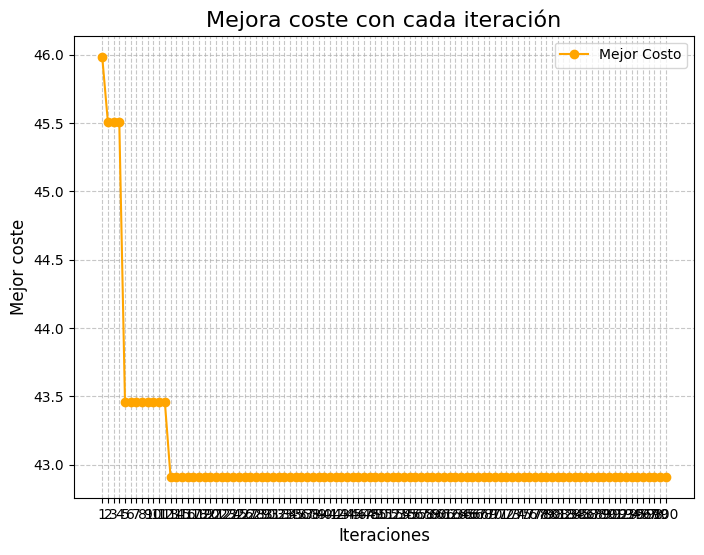

In [33]:

# Este segmento es una replica del apartado anterior pero modificado para unica y exclusivamente la grafica 
solucion_optima = None
mejor_precio = float('inf')
mejora_coste = []  

for iteration in range(num_iterations):
    soluciones = []
    costes = []

    for _ in range(num_vehiculos):
        solution = solucion_Vehiculo(df_distances, df_vehicles, df_customers["order_demand"])
        total_cost, vehicle_costes = calculo_Coste(solution, df_distances, df_vehicles)
        soluciones.append(solution)
        costes.append(total_cost)#Añadimos para la grafica

        if total_cost < mejor_precio:
            mejor_precio = total_cost
            solucion_optima = solution

    mejora_coste.append(mejor_precio)

    pheromone_matrix *= (1 - rho)
    for solution, cost in zip(soluciones, costes):
        for vehicle_name, routes in solution:
            for route in routes:
                for i in range(len(route) - 1):
                    pheromone_matrix[route[i]][route[i + 1]] += Q / cost

plt.figure(figsize=(8, 6))
plt.plot(mejora_coste, marker='o', color='orange', label="Mejor Costo")
plt.title("Mejora coste con cada iteración", fontsize=16)
plt.xlabel("Iteraciones", fontsize=12)
plt.ylabel("Mejor coste", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(mejora_coste)), range(1, len(mejora_coste) + 1))
plt.legend()
plt.show()